In [1]:
#Web Scrape
import time
import re
import os 
import json
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
from deep_translator import GoogleTranslator

#Data Wragling
import numpy as np
import pandas as pd

# Data process and model
import matplotlib.pyplot as plt
import seaborn as sns 
import findspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import IDF, Tokenizer, CountVectorizer, VectorAssembler, StopWordsRemover
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## Business problem 
### ChatGPT, OpenAI's AI-powered conversational system, debuted in late 2022 and quickly captured public attention as AI technology became more prevalent in our lives. Sentiment toward ChatGPT is mixed, with some seeing it as a valuable tool for everyday tasks while others advocate for its replacement by more advanced AI systems. The goal in this project is to analyze Twitter data to determine the predominant sentiment surrounding ChatGPT, shedding light on public opinion regarding its usage and impact.

## Scraper

### Firstly, lets create a data scraper with the goal to retrive tweets related to the topic "ChatGPT". I did this scraper without API connection because the free plan access to the API is limited to post and delete only, not allowing us to retrieve data from the user's tweets.

In [ ]:
service = Service(executable_path= 'chromedriver.exe')
driver = webdriver.Chrome(service= service)

In [ ]:
actions = ActionChains(driver)

In [ ]:
driver.get("https://twitter.com/search?q=ChatGPT&src=typed_query&f=top&lf=on")

In [ ]:
driver.find_elements(By.XPATH, '//div[@class="css-1rynq56 r-8akbws r-krxsd3 r-dnmrzs r-1udh08x r-bcqeeo r-qvutc0 r-1qd0xha r-a023e6 r-rjixqe r-16dba41 r-bnwqim"]')

In [ ]:
tweet = []

In [ ]:
for i in range(0,10):
     # Encontre todos os elementos de tweet com a classe específica
    tweet_elements = driver.find_elements(By.XPATH, '//div[@class="css-1rynq56 r-8akbws r-krxsd3 r-dnmrzs r-1udh08x r-bcqeeo r-qvutc0 r-1qd0xha r-a023e6 r-rjixqe r-16dba41 r-bnwqim"]')

    # Itere sobre os elementos e obtenha o texto de cada tweet
    for tweet_element in tweet_elements:
        tweet_text = tweet_element.text
        tweet.append(tweet_text)

    # Role a página para baixo
    actions.send_keys(Keys.PAGE_DOWN).perform()
    time.sleep(1)  # Aguarde um pouco após cada rolagem

In [ ]:
tweet

In [ ]:
df_tweets = pd.DataFrame(tweet, columns=['Tweets'])

In [ ]:
df_tweets = df_tweets.drop_duplicates()

In [ ]:
df_tweets.shape

In [ ]:
df_tweets.head(10)

In [ ]:
df_tweets['Tweets'] = df_tweets['Tweets'].str.replace('\n', ' ')

In [ ]:
df_tweets.head(10)

In [ ]:
df_tweets.to_csv('data/Tweets.csv', index= False)

In [ ]:
df_tweets['Tweets'][2]

In [ ]:
pd.read_csv('Tweets.csv')

In [ ]:
df_pd = pd.read_csv('../Sentiment-Analysis-ChatGPT/data/Tweets.csv')

In [ ]:
df_pd.head()

In [ ]:
df_pd['Tweets'] = [GoogleTranslator(source= 'auto', target = 'pt').translate(i) for i in df_pd['Tweets']]

In [ ]:
df_pd.to_csv('data/Tweets_translated.csv', index= False)

## Initializing the Spark 

In [2]:
findspark.init()

In [3]:
sc = SparkContext(appName= 'Twitter')

In [4]:
spark = SparkSession.builder.config("spark.executor.memory", "8g").config("spark.driver.memory", "8g").config("spark.driver.maxResultSize", "2048m").getOrCreate()

In [5]:
spark

In [6]:
# Defining schema of the CSV 
path = '../Sentiment-Analysis-ChatGPT/data/Tweets_translated.csv'
schema = StructType([StructField("Tweets", StringType(), True)])


In [7]:
df = spark.read.csv(path, inferSchema= True, schema = schema, header = True)

In [8]:
type(df)

pyspark.sql.dataframe.DataFrame

In [9]:
df.distinct()

DataFrame[Tweets: string]

In [10]:
def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    # Convert HTML references
    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)
    
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    
    #Remove laughs
    text = re.sub(r'\b(\w*(\w)\2{2,}\w*)\b', '', text)
    
    # Convert to lowercase
    text = text.lower()

    return text

In [11]:
df.dtypes

[('Tweets', 'string')]

In [12]:
type(df)

pyspark.sql.dataframe.DataFrame

In [13]:
df.take(5)

[Row(Tweets='pedi pro chat gpt fazer um roteiro de um fds em são paulo'),
 Row(Tweets='perguntei para o CHAT GPT como seria o cast dos X-Men se o filme fosse uma produção brasileira'),
 Row(Tweets='chatgpt prepare um texto explicando pra qa tudo que eu fiz nesse código e não deixe margem pra que ela faça perguntas'),
 Row(Tweets='Olá coleção de fotos “My vibe”. Preço mínimo de edição limitada 0,05 sol https://exchange.art/series/%E2%80%9CMy%20vibe%E2%80%9D%20photo%20collection./nfts…'),
 Row(Tweets='CHAT GPT, O PALMEIRAS ROUBOU OU NÃO?')]

In [14]:
pre_process_udf = udf(pre_process, StringType())

# Aplique a UDF à coluna 'Tweets'
df = df.withColumn('ProcessedTweets', pre_process_udf(df['Tweets']))


In [15]:
df = df.drop('Tweets')

In [16]:
df.tail(5)

[Row(ProcessedTweets='plataforma para estimular fãs curso rico mychatgpt 3635713652 daikailanv estimulando fãs no douyin estimulando fãs no twitter de forma eficiente'),
 Row(ProcessedTweets='ins fãs twitter seguidores eficientemente discord conta chatgpt google caixa de correio estratégia little type9407640018'),
 Row(ProcessedTweets='abra o v azul em nome do telegram para aprimorar seguidores chatgpt dez medidas qualquer outro verde vermelho twitter para aprimorar seguidores de forma eficiente e tiktok para aprimorar curtidas 9624095949'),
 Row(ProcessedTweets='chatgpt ativação chatgptplus conta chatgpt atacado aluguel de conta chatgpt número chatgpt versão do computador chatgpt'),
 Row(ProcessedTweets='7751060875 xiaohongshu fan ins fãs twitter plataforma de fãs de alta eficiência chatgpt a capacidade desta noite deve se preocupar')]

### Building necessary steps

In [17]:
tokenizer = Tokenizer(inputCol="ProcessedTweets", outputCol="words")
tokenized = tokenizer.transform(df)

In [18]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords= StopWordsRemover.loadDefaultStopWords('portuguese'))
removed = remover.transform(tokenized)

### Creating a list of word that was previously spotted in a superficial analysis 

In [19]:
add_stopwords = ['pra','pro','mim','tipo','vc','ne','to','hein','mt','ir','k', '']

In [20]:
sec_remover = StopWordsRemover(inputCol="filtered_words", outputCol="filtered_twice_words", stopWords= add_stopwords)

In [21]:
removed_twice = sec_remover.transform(removed)

### Creating a CountVectorizer to be able to retrieve vocabulary words

In [22]:
cv = CountVectorizer(inputCol="filtered_twice_words", outputCol='rawfeature')

In [23]:
cv_model= cv.fit(removed_twice)

In [24]:
featurizedData = cv_model.transform(removed_twice)

In [25]:
vocabulary = cv_model.vocabulary

### After obtaining this count vectorizer, we need to pass it into the IDF function. This function will add weights to each word. The more frequent the word is, the lower its weight, and vice versa. This allows us to compensate for the bias in a large corpus of text like ours.

In [26]:
cv_idf = IDF(inputCol='rawfeature', outputCol='features')
cv_idf_model = cv_idf.fit(featurizedData)
rescaledData = cv_idf_model.transform(featurizedData)

In [27]:
rescaledData.select('filtered_twice_words','features').take(2)

[Row(filtered_twice_words=['pedi', 'chat', 'gpt', 'fazer', 'roteiro', 'fds', 'paulo'], features=SparseVector(2919, {1: 1.1336, 2: 1.2216, 7: 2.9832, 71: 4.0128, 269: 4.7059, 375: 4.9291, 2708: 5.6222})),
 Row(filtered_twice_words=['perguntei', 'chat', 'gpt', 'cast', 'xmen', 'filme', 'produção', 'brasileira'], features=SparseVector(2919, {1: 1.1336, 2: 1.2216, 135: 4.3694, 205: 4.7059, 244: 4.7059, 344: 4.9291, 620: 5.2167, 2867: 5.6222}))]

# Sentiment analysis 

In [28]:
removed_twice.take(5)

[Row(ProcessedTweets='pedi pro chat gpt fazer um roteiro de um fds em são paulo', words=['pedi', 'pro', 'chat', 'gpt', 'fazer', 'um', 'roteiro', 'de', 'um', 'fds', 'em', 'são', 'paulo'], filtered_words=['pedi', 'pro', 'chat', 'gpt', 'fazer', 'roteiro', 'fds', 'paulo'], filtered_twice_words=['pedi', 'chat', 'gpt', 'fazer', 'roteiro', 'fds', 'paulo']),
 Row(ProcessedTweets='perguntei para o chat gpt como seria o cast dos xmen se o filme fosse uma produção brasileira', words=['perguntei', 'para', 'o', 'chat', 'gpt', 'como', 'seria', 'o', 'cast', 'dos', 'xmen', 'se', 'o', 'filme', 'fosse', 'uma', 'produção', 'brasileira'], filtered_words=['perguntei', 'chat', 'gpt', 'cast', 'xmen', 'filme', 'produção', 'brasileira'], filtered_twice_words=['perguntei', 'chat', 'gpt', 'cast', 'xmen', 'filme', 'produção', 'brasileira']),
 Row(ProcessedTweets='chatgpt prepare um texto explicando pra qa tudo que eu fiz nesse código e não deixe margem pra que ela faça perguntas', words=['chatgpt', 'prepare', 'um

In [29]:
removed_twice.show()

+--------------------+--------------------+--------------------+--------------------+
|     ProcessedTweets|               words|      filtered_words|filtered_twice_words|
+--------------------+--------------------+--------------------+--------------------+
|pedi pro chat gpt...|[pedi, pro, chat,...|[pedi, pro, chat,...|[pedi, chat, gpt,...|
|perguntei para o ...|[perguntei, para,...|[perguntei, chat,...|[perguntei, chat,...|
|chatgpt prepare u...|[chatgpt, prepare...|[chatgpt, prepare...|[chatgpt, prepare...|
|olá coleção de fo...|[olá, coleção, de...|[olá, coleção, fo...|[olá, coleção, fo...|
|chat gpt o palmei...|[chat, gpt, o, pa...|[chat, gpt, palme...|[chat, gpt, palme...|
|amor perigoso 11 ...|[amor, perigoso, ...|[amor, perigoso, ...|[amor, perigoso, ...|
|canal 3blue1brown...|[canal, 3blue1bro...|[canal, 3blue1bro...|[canal, 3blue1bro...|
|até o chat gpt ta...|[até, o, chat, gp...|[chat, gpt, ta, s...|[chat, gpt, ta, s...|
|canal 3blue1brown...|[canal, 3blue1bro...|[canal, 3bl

### Creating portuguese lexicon dict 

In [30]:
#Importando o Léxico de Palavras com polaridades
sentilexpt = open('../Sentiment-Analysis-ChatGPT/data/SentiLex-flex-PT02.txt', encoding='utf-8')

#Criando um dicionário de palavras com a respectiva polaridade.
dic_polarity_word = {}
for i in sentilexpt.readlines():
  comma_pos = i.find(',')
  word = i[:comma_pos]
  pol_pos = i.find('POL')
  polarity = (i[pol_pos+7:pol_pos+9]).replace(';', '')
  dic_polarity_word[word] = polarity


#Verificando o dicionário

dic_polarity_word

{'à-vontade': '1',
 'abafada': '-1',
 'abafadas': '-1',
 'abafado': '-1',
 'abafados': '-1',
 'abafante': '-1',
 'abafantes': '-1',
 'abaixada': '-1',
 'abaixadas': '-1',
 'abaixado': '-1',
 'abaixados': '-1',
 'abalada': '-1',
 'abaladas': '-1',
 'abalado': '-1',
 'abalados': '-1',
 'abalizada': '1',
 'abalizadas': '1',
 'abalizado': '1',
 'abalizados': '1',
 'abalroa': '1',
 'abalroá': '1',
 'abalroada': '-1',
 'abalroadas': '-1',
 'abalroado': '1',
 'abalroados': '-1',
 'abalroai': '1',
 'abalroais': '1',
 'abalroam': '1',
 'abalroámo': '1',
 'abalroamo': '1',
 'abalroámos': '1',
 'abalroamos': '1',
 'abalroando': '1',
 'abalroar': '1',
 'abalroará': '1',
 'abalroara': '1',
 'abalroaram': '1',
 'abalroáramo': '1',
 'abalroáramos': '1',
 'abalroarão': '1',
 'abalroarás': '1',
 'abalroaras': '1',
 'abalroarde': '1',
 'abalroardes': '1',
 'abalroare': '1',
 'abalroarei': '1',
 'abalroárei': '1',
 'abalroareis': '1',
 'abalroáreis': '1',
 'abalroarem': '1',
 'abalroaremos': '1',
 'abalr

In [31]:
# Registre a função UDF
def Sentiment_score_spark(sentence):
    l_sentiment = []
    for w in sentence:
        l_sentiment.append(int(dic_polarity_word.get(w, 0)))
    score = np.sum(l_sentiment)
    if score > 0:
        return 'Pos {}'.format(score)
    elif score == 0:
        return 'Neu {}'.format(score)
    else:
        
        return 'Neg {}'.format(score)
Sentiment_score_udf = udf(Sentiment_score_spark, StringType())

In [32]:
Sentiment_score = removed_twice.withColumn('Sentiment_score', Sentiment_score_udf(removed_twice['filtered_twice_words']))

In [33]:
Sentiment_score.show()

+--------------------+--------------------+--------------------+--------------------+---------------+
|     ProcessedTweets|               words|      filtered_words|filtered_twice_words|Sentiment_score|
+--------------------+--------------------+--------------------+--------------------+---------------+
|pedi pro chat gpt...|[pedi, pro, chat,...|[pedi, pro, chat,...|[pedi, chat, gpt,...|          Neu 0|
|perguntei para o ...|[perguntei, para,...|[perguntei, chat,...|[perguntei, chat,...|          Neu 0|
|chatgpt prepare u...|[chatgpt, prepare...|[chatgpt, prepare...|[chatgpt, prepare...|          Neu 0|
|olá coleção de fo...|[olá, coleção, de...|[olá, coleção, fo...|[olá, coleção, fo...|         Neg -1|
|chat gpt o palmei...|[chat, gpt, o, pa...|[chat, gpt, palme...|[chat, gpt, palme...|         Neg -1|
|amor perigoso 11 ...|[amor, perigoso, ...|[amor, perigoso, ...|[amor, perigoso, ...|         Neg -1|
|canal 3blue1brown...|[canal, 3blue1bro...|[canal, 3blue1bro...|[canal, 3blue1bro.

In [34]:
def extract_sentiment(sentiment_score):
    sentiment = sentiment_score.strip()[0:4]
    return sentiment

extract_sentiment_udf = udf(extract_sentiment, StringType())

In [35]:
Sentiment_score = Sentiment_score.withColumn('Sentiment', extract_sentiment_udf(Sentiment_score['Sentiment_score']))

In [36]:
Sentiment_score.show()

+--------------------+--------------------+--------------------+--------------------+---------------+---------+
|     ProcessedTweets|               words|      filtered_words|filtered_twice_words|Sentiment_score|Sentiment|
+--------------------+--------------------+--------------------+--------------------+---------------+---------+
|pedi pro chat gpt...|[pedi, pro, chat,...|[pedi, pro, chat,...|[pedi, chat, gpt,...|          Neu 0|     Neu |
|perguntei para o ...|[perguntei, para,...|[perguntei, chat,...|[perguntei, chat,...|          Neu 0|     Neu |
|chatgpt prepare u...|[chatgpt, prepare...|[chatgpt, prepare...|[chatgpt, prepare...|          Neu 0|     Neu |
|olá coleção de fo...|[olá, coleção, de...|[olá, coleção, fo...|[olá, coleção, fo...|         Neg -1|     Neg |
|chat gpt o palmei...|[chat, gpt, o, pa...|[chat, gpt, palme...|[chat, gpt, palme...|         Neg -1|     Neg |
|amor perigoso 11 ...|[amor, perigoso, ...|[amor, perigoso, ...|[amor, perigoso, ...|         Neg -1|   

In [37]:
Sentiment_score.groupBy('Sentiment').count().show()

+---------+-----+
|Sentiment|count|
+---------+-----+
|     Pos |  110|
|     Neg |  163|
|     Neu |  279|
+---------+-----+



In [38]:
def sentiment_spark(word):
    if int(dic_polarity_word.get(word, 0)) > 0:
        return 'Pos'
    elif (int(dic_polarity_word.get(word, 0))) == 0:
        return 'Neu'
    else:
        return 'Neg'
sentiment_spark_udf = udf(sentiment_spark, StringType())

In [39]:
words = removed_twice.select(explode(col("filtered_twice_words")).alias("word"))

In [40]:
words.groupBy("word").count().orderBy('count', ascending = False).show()

+--------+-----+
|    word|count|
+--------+-----+
| chatgpt|  365|
|     gpt|  181|
|    chat|  166|
|       é|  139|
|      ia|   66|
|    aqui|   37|
|    usar|   33|
|   fazer|   32|
|      ai|   27|
|    pode|   26|
|   agora|   26|
|     vai|   24|
|  google|   22|
|       3|   21|
|   conta|   21|
|   sobre|   21|
|batepapo|   19|
|     ser|   19|
|  usando|   18|
|trabalho|   18|
+--------+-----+
only showing top 20 rows



In [41]:
words.drop_duplicates().describe().show()

+-------+--------------------+
|summary|                word|
+-------+--------------------+
|  count|                2919|
|   mean|4.4057758621568626E8|
| stddev|1.7780031624311645E9|
|    min|                   0|
|    max|                útil|
+-------+--------------------+



In [42]:
words = words.withColumn('Sentiment_score', sentiment_spark_udf(words['word']))

In [43]:
words.show()

+----------+---------------+
|      word|Sentiment_score|
+----------+---------------+
|      pedi|            Neu|
|      chat|            Neu|
|       gpt|            Neu|
|     fazer|            Neu|
|   roteiro|            Neu|
|       fds|            Neu|
|     paulo|            Neu|
| perguntei|            Neu|
|      chat|            Neu|
|       gpt|            Neu|
|      cast|            Neu|
|      xmen|            Neu|
|     filme|            Neu|
|  produção|            Neu|
|brasileira|            Neu|
|   chatgpt|            Neu|
|   prepare|            Neu|
|     texto|            Neu|
|explicando|            Neu|
|        qa|            Neu|
+----------+---------------+
only showing top 20 rows



In [44]:
words.describe().show()

+-------+--------------------+---------------+
|summary|                word|Sentiment_score|
+-------+--------------------+---------------+
|  count|                6370|           6370|
|   mean|1.5603799014583334E8|           NULL|
| stddev| 1.072407298991234E9|           NULL|
|    min|                   0|            Neg|
|    max|                útil|            Pos|
+-------+--------------------+---------------+



In [45]:
words.groupBy(['word','Sentiment_score']).count().orderBy('count', ascending=False).filter(words['Sentiment_score'] == 'Neg').show()

+-----------+---------------+-----+
|       word|Sentiment_score|count|
+-----------+---------------+-----+
|       usar|            Neg|   33|
|     usando|            Neg|   18|
|        uso|            Neg|   12|
|manipulação|            Neg|    9|
| artificial|            Neg|    9|
|   obrigado|            Neg|    8|
| manipulado|            Neg|    7|
|        usa|            Neg|    6|
|   problema|            Neg|    5|
|        use|            Neg|    5|
|       erro|            Neg|    5|
|       usei|            Neg|    4|
|     garota|            Neg|    4|
|      sugar|            Neg|    4|
|       usou|            Neg|    4|
|      morte|            Neg|    3|
|    passado|            Neg|    3|
|       ruim|            Neg|    3|
|     errado|            Neg|    3|
|     perder|            Neg|    3|
+-----------+---------------+-----+
only showing top 20 rows



In [46]:
Sentiment_score_df = Sentiment_score.groupBy('Sentiment').count().toPandas()

In [47]:
Sentiment_score_df.head()

,Sentiment,count
0,Pos,110
1,Neg,163
2,Neu,279


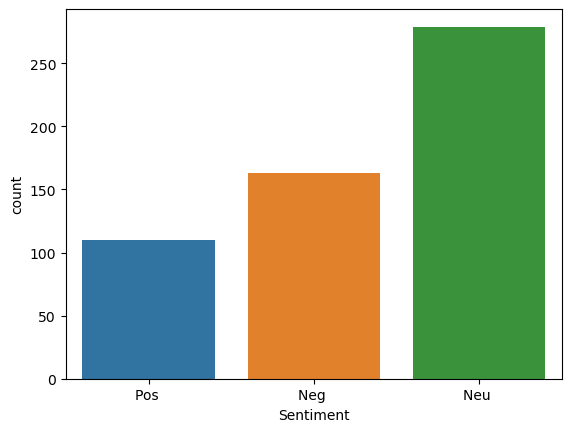

In [49]:
sns.barplot(x= Sentiment_score_df.Sentiment, y= Sentiment_score_df['count'])
plt.savefig('../Sentiment-Analysis-ChatGPT/data/Sentiment_distribution')

### Apparently, the retrieved tweets contains an neutral content, based on the used lexicon. Lets'see the most commom words utilized and have a wider view above what is sayed. 

# Creating a Wordcloud 

In [50]:
wordcloud_w = ""
for w in vocabulary:
    wordcloud_w += w+" "

In [51]:
wordcloud_w

'chatgpt gpt chat é ia aqui usar fazer ai agora pode vai google sobre conta 3 ser batepapo usando trabalho textor melhor loli openai prova twitter tudo 1 sempre 2 alguém contraste então hoje hardik uso texto tempo pessoas email vídeo copilot conteúdo apenas chama tá veja escrever ter ainda deve q us música dia todos resposta ajuda tecnologia x manipulação vou gente passo feito inteligência bem artificial diz sabe uns pedi criar gemini ver favor imagens 100 qualquer artigo gerar aí fazendo jogo tô faz microsoft ano seguidores amamos obrigado provas amo casa disse tão horas ferramentas precisa manipulado desse todo porque usuários nada coisa minutos john fãs sim momento 5 sei pergunta botafogo gratuito dizer ajudar claude número 2024 gpt4 posso pq versão recursos cara assim fã fala código responder artigos fez respostas perguntei usa prompt fiz mano novo deveria palavra chatbot jogar futuro dalle 4 nunca estudo assunto voz tanto alunos time problema forma bing negócios mal torna erro tex

In [52]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_w)

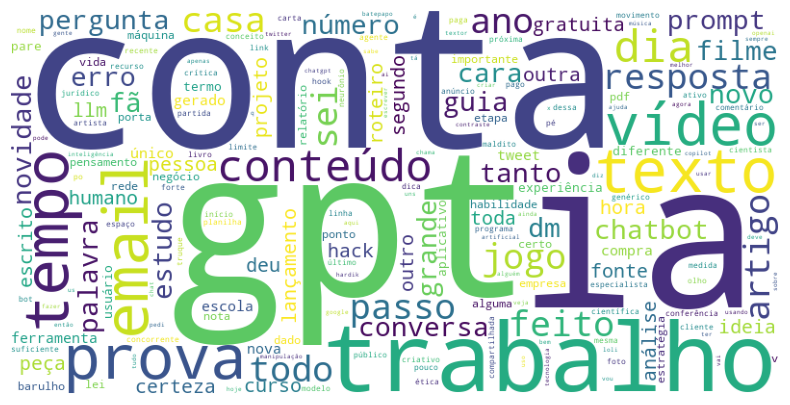

In [53]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud.to_file('../Sentiment-Analysis-ChatGPT/data/WordCloud_Sentiment_Distribution.png')

### As we can see, the most commom used words are "gpt", "texto", "ia", "trabalho". These words can be linked to the use of the technology, as we could use the ChatGPT to improve our performance at tasks like creating and analyse text, and several things related to daily task on job. Those words are not enough to say that the content on the tweets are positive or negative yet, so let's create a word cloud to the words that were classified as positive, negative and neutral.

# Analysing by sentiment 

In [54]:
neg_words = words.groupBy(['word','Sentiment_score']).count().orderBy('count', ascending=False).filter(words['Sentiment_score'] == 'Neg').toPandas()
pos_words = words.groupBy(['word','Sentiment_score']).count().orderBy('count', ascending=False).filter(words['Sentiment_score'] == 'Pos').toPandas()
neu_words = words.groupBy(['word','Sentiment_score']).count().orderBy('count', ascending=False).filter(words['Sentiment_score'] == 'Neu').toPandas()

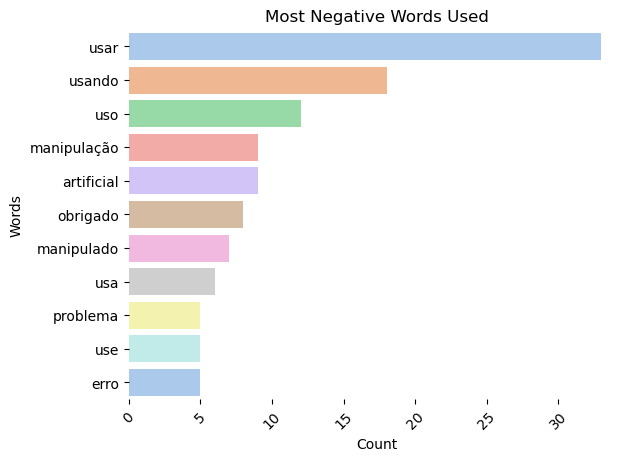

In [55]:
sns.barplot(data= neg_words[0:11], y='word',x='count', palette= 'pastel')
sns.despine(left=True, bottom=True)
plt.xticks(rotation = 45)
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Most Negative Words Used')
plt.savefig('../Sentiment-Analysis-ChatGPT/data/Negative_Sentiment_Analysis.png', bbox_inches='tight', pad_inches=0)

### Words like "usar" and "manipulação" demonstrate the concerns of the users around the use and manipulation of the results given by the ChatGPT.
### Words like "artificial" and "manipulado" have a negative connotation around the wider concerns about confiability and autenticity of the Artificial Intelligence.
### Words like "obrigado", "problema" e "erro" suggests that the user may be facing issues around the use of the ChatGPT, indicating a negative feedback.
### With all those thing in mind, we need to take into account that the context of the entire tweet must be considered, because those words can be used in contexts that are not negative.

In [56]:
wordcloud_neg = ""
for w in list(words[words['Sentiment_score'] == 'Neg'].toPandas()['word']):
    wordcloud_neg += w+" "

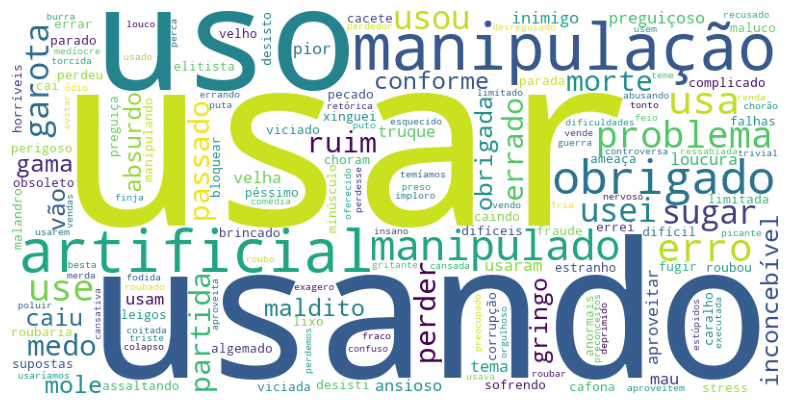

In [57]:
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_neg)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()
wordcloud_negative.to_file('../Sentiment-Analysis-ChatGPT/data/WordCloud_Sentiment_Negative.png')

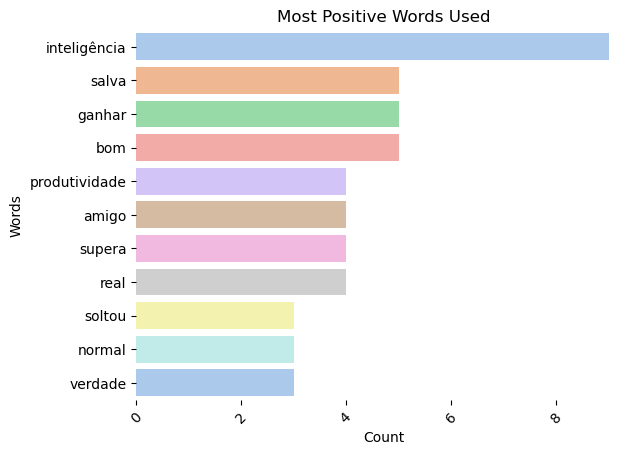

In [58]:
sns.barplot(data= pos_words[0:11], y='word',x='count', palette= 'pastel')
sns.despine(left=True, bottom=True)
plt.xticks(rotation = 45)
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Most Positive Words Used')
plt.savefig('../Sentiment-Analysis-ChatGPT/data/Positive_Sentiment_Analysis.png', bbox_inches='tight', pad_inches=0)


### Words like "inteligência", "bom" and "produtividade" suggests that the users have a posiive perception of ChatGPT, where those words are associated with desirable qualitys of the technology, with efficiency, utility and confiablity
### Words like "salva", "ganhar" and "supera" can indicate that the ChatGPT is able to give effective solutions and overcome expectations, resulting in a greater confiability in the technology.
### Words like "bom", "produtividade" and "normal" can suggest that the users recognize the benefits and advantages around the use of the ChatGPT, which it can be the increase of the efficiency and facilitating tasks.

In [59]:
wordcloud_pos = ""
for w in list(words[words['Sentiment_score'] == 'Pos'].toPandas()['word']):
    wordcloud_pos += w+" "

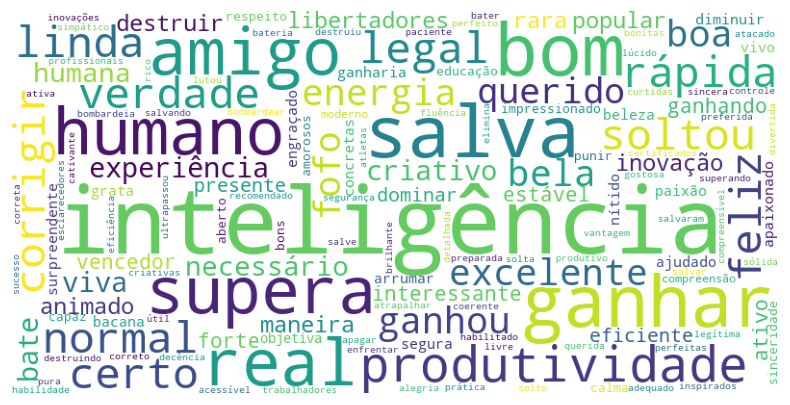

In [60]:
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.show()
wordcloud_positive.to_file('../Sentiment-Analysis-ChatGPT/data/WordCloud_Sentiment_Positive.png')

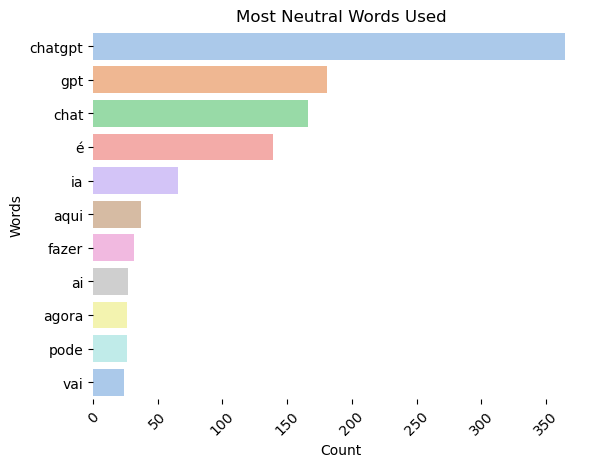

In [61]:
sns.barplot(data= neu_words[0:11], y='word',x='count', palette= 'pastel')
sns.despine(left=True, bottom=True)
plt.xticks(rotation = 45)
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Most Neutral Words Used')
plt.savefig('../Sentiment-Analysis-ChatGPT/data/Neutral_Sentiment_Analysis.png', bbox_inches='tight', pad_inches=0)


In [62]:
wordcloud_neu = ""
for w in list(words[words['Sentiment_score'] == 'Neu'].toPandas()['word']):
    wordcloud_neu += w+" "

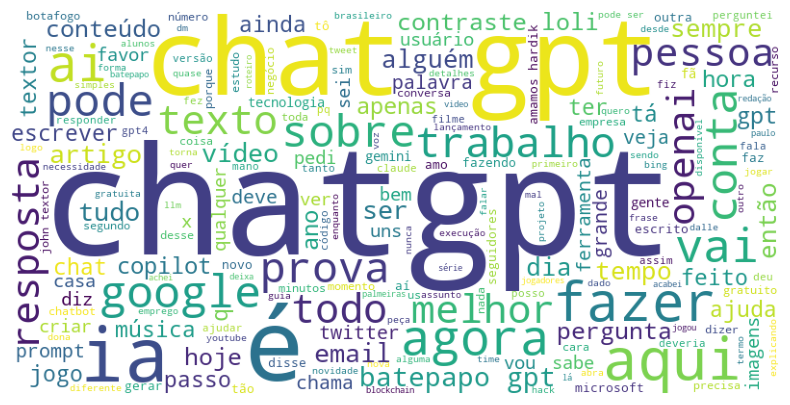

In [63]:
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_neu)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral)
plt.axis('off')
plt.show()
wordcloud_neutral.to_file('../Sentiment-Analysis-ChatGPT/data/WordCloud_Sentiment_Neutral.png')

### In general, the utilized words were to mention the ChatGPT or reference the Artificial Intelligence and technologies envolved to this environment, and words like "é", "aqui" , "fazer" are commonly used in conversations, dont having an negative ou positive emotion.

### It seems like the dominant sentiment is the neutral one with slightly positivity, because the negative words that have more frequency are more dependent on the given context than the positive ones. 
### With the neutral words, looks like the users talk about ChatGPT and the technology in your daily uses. 


# LDA Model 


In [64]:
#Assuming k = 3
lda = LDA(k=3, maxIter=500)

In [65]:
LDA_CV_IDF = lda.fit(rescaledData)

In [66]:
LDA_CV_IDF.describeTopics().show(5)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[7, 0, 4, 3, 2, 1...|[0.00753940093950...|
|    1|[1, 2, 20, 11, 3,...|[0.01124145339460...|
|    2|[3, 14, 4, 0, 10,...|[0.00831313668856...|
+-----+--------------------+--------------------+



In [67]:
transformed_LDA_CV_IDF = LDA_CV_IDF.transform(rescaledData)

In [68]:
transformed_LDA_CV_IDF.show(1)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     ProcessedTweets|               words|      filtered_words|filtered_twice_words|          rawfeature|            features|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|pedi pro chat gpt...|[pedi, pro, chat,...|[pedi, pro, chat,...|[pedi, chat, gpt,...|(2919,[1,2,7,71,2...|(2919,[1,2,7,71,2...|[0.00146391683062...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [69]:
topic_indices_CV_IDF = LDA_CV_IDF.describeTopics(maxTermsPerTopic= 10)

In [70]:
topic_indices_CV_IDF.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[7, 0, 4, 3, 2, 1...|[0.00753940093950...|
|    1|[1, 2, 20, 11, 3,...|[0.01124145339460...|
|    2|[3, 14, 4, 0, 10,...|[0.00831313668856...|
+-----+--------------------+--------------------+



In [71]:
def indices_to_terms(vocabulary):
    def indices_to_terms(xs):
        return [vocabulary[int(x)] for x in xs]
    return udf(indices_to_terms, ArrayType(StringType()))

# Para cada tópico, mapeie os índices do termo de volta para as palavras usando o vocabulário

topics_with_terms_CV = topic_indices_CV_IDF.withColumn("termIndices", indices_to_terms(vocabulary)(col("termIndices")))

topics_with_terms_CV.show(truncate=False)

+-----+--------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                         |termWeights                                                                                                                                                                                                                  |
+-----+--------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[fazer, chatgpt, ia, é, chat, trabalho, gpt, usar, aqui, conteúdo]  |[0.007539400939505435, 0.00

In [72]:
term_weights = topics_with_terms_CV.toPandas()

In [73]:
term_weights

,topic,termIndices,termWeights
0,0,"[fazer, chatgpt, ia, é, chat, trabalho, gpt, u...","[0.007539400939505435, 0.006978868453430666, 0..."
1,1,"[gpt, chat, textor, vai, é, chatgpt, prova, lo...","[0.011241453394602705, 0.01085001628449297, 0...."
2,2,"[é, conta, ia, chatgpt, pode, música, agora, p...","[0.008313136688565998, 0.008286950476149095, 0..."


In [74]:
term_weights['topic'] = term_weights['topic'].astype(int)

In [75]:
term_weights.dtypes

topic           int32
termIndices    object
termWeights    object
dtype: object

In [76]:
term_weights.explode('termIndices').drop(columns='termWeights')

,topic,termIndices
0,0,fazer
0,0,chatgpt
0,0,ia
0,0,é
0,0,chat
0,0,trabalho
0,0,gpt
0,0,usar
0,0,aqui
0,0,conteúdo


In [77]:
term_weights.explode('termWeights').drop(columns='termIndices')

,topic,termWeights
0,0,0.007539
0,0,0.006979
0,0,0.006406
0,0,0.006206
0,0,0.006141
0,0,0.005889
0,0,0.005777
0,0,0.005384
0,0,0.005216
0,0,0.005086


In [78]:
term_weights_df = pd.concat([term_weights.explode('termIndices').drop(columns='termWeights'), term_weights.explode('termWeights').drop(columns='termIndices')], axis= 1).reset_index()

In [79]:
term_weights_df

,index,topic,termIndices,topic,termWeights
0,0,0,fazer,0,0.007539
1,0,0,chatgpt,0,0.006979
2,0,0,ia,0,0.006406
3,0,0,é,0,0.006206
4,0,0,chat,0,0.006141
5,0,0,trabalho,0,0.005889
6,0,0,gpt,0,0.005777
7,0,0,usar,0,0.005384
8,0,0,aqui,0,0.005216
9,0,0,conteúdo,0,0.005086


In [80]:
term_weights_df.drop(columns=term_weights_df.columns[1], inplace= True)

In [81]:
term_weights_df.rename(columns={'index':'Topic'}, inplace= True)

In [82]:
term_weights_df.head(10)

,Topic,termIndices,termWeights
0,0,fazer,0.007539
1,0,chatgpt,0.006979
2,0,ia,0.006406
3,0,é,0.006206
4,0,chat,0.006141
5,0,trabalho,0.005889
6,0,gpt,0.005777
7,0,usar,0.005384
8,0,aqui,0.005216
9,0,conteúdo,0.005086


In [83]:
term_weights_df['Topic'].describe()

count    30.000000
mean      1.000000
std       0.830455
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       2.000000
Name: Topic, dtype: float64

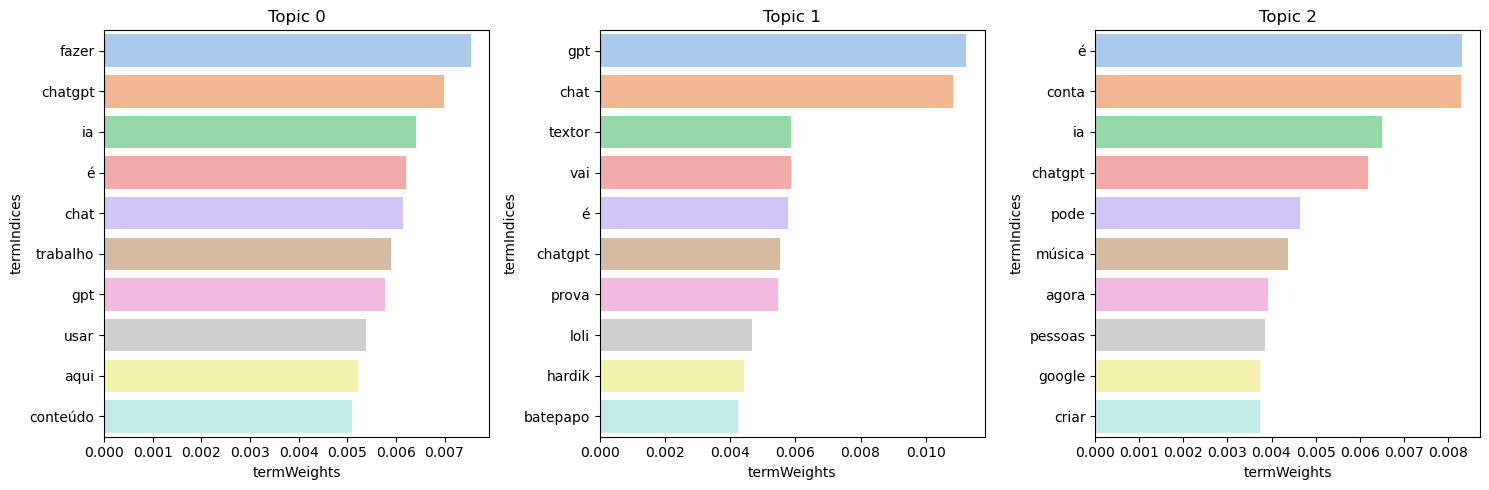

<Figure size 640x480 with 0 Axes>

In [84]:
plt.figure(figsize=(15, 5))  # Ajuste o tamanho da figura para a largura desejada

for i in range(0, 3):
    plt.subplot(1, 3, i+1)  # Subplot em uma linha com três colunas
    sns.barplot(data=term_weights_df[term_weights_df['Topic'] == i], y='termIndices', x='termWeights', palette='pastel')
    plt.title('Topic {}'.format(i))

plt.tight_layout()
plt.show()
plt.savefig('../Sentiment-Analysis-ChatGPT/data/LDA_Topics.png')

In [85]:
transformed_LDA_CV_IDF.select("ProcessedTweets", "topicDistribution").collect()

[Row(ProcessedTweets='pedi pro chat gpt fazer um roteiro de um fds em são paulo', topicDistribution=DenseVector([0.0015, 0.9972, 0.0014])),
 Row(ProcessedTweets='perguntei para o chat gpt como seria o cast dos xmen se o filme fosse uma produção brasileira', topicDistribution=DenseVector([0.0011, 0.0015, 0.9973])),
 Row(ProcessedTweets='chatgpt prepare um texto explicando pra qa tudo que eu fiz nesse código e não deixe margem pra que ela faça perguntas', topicDistribution=DenseVector([0.0006, 0.0873, 0.912])),
 Row(ProcessedTweets='olá coleção de fotos my vibe preço mínimo de edição limitada 005 sol ', topicDistribution=DenseVector([0.0006, 0.9988, 0.0006])),
 Row(ProcessedTweets='chat gpt o palmeiras roubou ou não', topicDistribution=DenseVector([0.0028, 0.9946, 0.0026])),
 Row(ProcessedTweets='amor perigoso 11 2 sol ', topicDistribution=DenseVector([0.0015, 0.9972, 0.0013])),
 Row(ProcessedTweets='canal 3blue1brown soltou um video explicando gpt visualmente é um excelente complemento 

In [86]:
def extract_max_index(vector):
    return int(np.argmax(vector))

# Registre a função UDF
extract_max_index_udf = udf(extract_max_index, IntegerType())

LDA_CV_IDF_df = transformed_LDA_CV_IDF.withColumn('Group', extract_max_index_udf('topicDistribution'))

In [87]:
LDA_CV_IDF_df.groupBy('Group').agg(count('Group')).show()

+-----+------------+
|Group|count(Group)|
+-----+------------+
|    1|         220|
|    2|         162|
|    0|         170|
+-----+------------+



### Conclusion
### Upon utilizing LDA to model topics and conducting sentiment analysis, it appears that the majority of tweets discuss the usage of ChatGPT and the impact of artificial intelligence on users' daily consumption habits. The prevalence of a neutral sentiment, with a slight inclination towards positivity, suggests that users perceive ChatGPT as a beneficial tool in their daily lives. However, the nuance of sentiment could indicate a complex attitude towards AI technology, perhaps reflecting a cautious optimism or a recognition of both its advantages and potential limitations. Further exploration into the specific themes and sentiments expressed in the tweets could provide deeper insights into users' perceptions and attitudes towards ChatGPT and AI in general. Additionally, considering variations in sentiment across different user demographics or topics of discussion may reveal nuanced perspectives and uncover opportunities for improving user experience or addressing concerns.